# **Implementation of a Neural Network *"from scratch"* with NumPy**

In [1]:
import math
import numpy as np
from typing import Tuple
from typing import List

In [2]:
class LayerInitializer:
    """
    Functions for layer weight initialization.
    """

    # He normal initialization
    @staticmethod
    def he_normal(size: Tuple[int], fan_in: int) -> np.array:
        """
        HE NORMAL INITIALIZATION
        Draws samples from a truncated normal distribution centered at 0 mean
        with stddev = sqrt(2 / fan_in) where fan_in is the number of input
        units per unit in the layer.
        Parameters:
            - size: Tuple[int] (rows, columns)
                    shape of the initialized weight matrix
            - fan_in: int
                    number of input units per unit in the layer
        Returns:
            - np.array (rows, columns)
                    He normal initialized weight matrix
        Ref:
            https://arxiv.org/abs/1502.01852
        """
        return np.random.normal(0, math.sqrt(2 / fan_in), size = size)

    # Glorot / Xavier normal initialization
    @staticmethod
    def glorot_normal(size: Tuple[int], fan_in: int, fan_out: int) -> np.array:
        """
        GLOROT / XAVIER NORMAL INITIALIZATION
        Draws samples from a truncated normal distribution centered at 0 mean
        with stddev = sqrt(2 / (fan_in + fan_out)) where fan_in is the number of
        input units per unit in the layer and fan_out is the number of output
        units per unit in the layer.
        Parameters:
            - size: Tuple[int] (rows, columns)
                    shape of the initialized weight matrix
            - fan_in: int
                    number of input units per unit in the layer
            - fan_out: int
                    number of output units per unit in the layer
        Returns:
            - np.array (rows, columns)
                    Glorot normal initialized weight matrix
        Ref:
            http://proceedings.mlr.press/v9/glorot10a.html
        """
        return np.random.normal(0, math.sqrt(2 / (fan_in + fan_out)), size = size)

    # Bias initialization
    @staticmethod
    def bias(size: Tuple[int]):
        """
        BIAS INITIALIZATION
        Initializes the bias vector / matrix with zeros.
        Parameters:
            - size: Tuple[int] (rows, columns)
                    shape of the initialized bias vector / matrix
        Returns:
            - np.array (rows, columns)
                    Zero initialized bias vector / matrix
        Ref:
            https://cs231n.github.io/neural-networks-2/
        """
        return np.zeros(shape = size)

In [3]:
class ActivationFunctions:
    """
    Layer activation functions.
    """

    # Rectified Linear Units
    @staticmethod
    def relu(x: np.array, derivative: bool = False) -> np.array:
        """
        RECTIFIED LINEAR UNITS
        ReLU activation function.
        Parameters:
            - x: np.array
                    input matrix to apply activation function to
            - derivative: bool
                    if set to 'True' returns the derivative instead
                    DEFAULT: False
        Returns:
            - np.array (same shape as x)
                    activated x / derivative of x
        Ref:
            https://en.wikipedia.org/wiki/Rectifier_(neural_networks)
        """
        if not derivative:
            return np.maximum(x, 0)
        else:
            return np.where(x > 0, 1, 0)

    # Sigmoid activation function
    @staticmethod
    def sigmoid(x: np.array, derivative: bool = False) -> np.array:
        """
        SIGMOID / LOGISTIC FUNCTION
        Sigmoid activation function.
        Parameters:
            - x: np.array
                    input matrix to apply activation function to
            - derivative: bool
                    if set to 'True' returns the derivative instead
                    DEFAULT: False
        Returns:
            - np.array (same shape as x)
                    activated x / derivative of x
        Refs:
            https://en.wikipedia.org/wiki/Sigmoid_function
            https://en.wikipedia.org/wiki/Activation_function
        """
        def f_sigmoid(x: np.array) -> np.array:
            return 1 / (1 + np.exp(-x))

        if not derivative:
            return f_sigmoid(x)
        else:
            return f_sigmoid(x) * (1 - f_sigmoid(x))

    # Softmax activation function
    @staticmethod
    def softmax(x: np.array, derivative: bool = False) -> np.array:
        """
        SOFTMAX FUNCTION
        Stable softmax activation function.
        Parameters:
            - x: np.array
                    input matrix to apply activation function to
        Returns:
            - np.array (same shape as x)
                    activated x
        Refs:
            https://en.wikipedia.org/wiki/Softmax_function
            https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/
        """
        if not derivative:
            n = np.exp(x - np.max(x)) # stable softmax
            d = np.sum(n, axis = 0)
            return n / d
        else:
            raise NotImplementedError("Softmax derivative not implemented!")
            # https://stackoverflow.com/questions/54976533/derivative-of-softmax-function-in-python
            # xr = x.reshape((-1, 1))
            # return np.diagflat(x) - np.dot(xr, xr.T)

In [4]:
class LossFunctions:
    """
    Loss functions for neural net fitting.
    """

    # binary cross entropy loss
    @staticmethod
    def binary_cross_entropy(y_true: np.array, y_predicted: np.array) -> np.array:
        """
        BINARY CROSS ENTROPY LOSS
        Cross entropy loss for binary-class classification.
        L[BCE] = - p(i) * log(q(i)) - (1 - p(i)) * log(1 - q(i))
        where
            - p(i) is the true label
            - q(i) is the predicted sigmoid probability
        Parameters:
            - y_true: np.array (1, sample_size)
                    true label vector
            - y_predicted: np.array (1, sample_size)
                    the sigmoid probability
        Returns:
            - np.array (sample_size,)
                    loss for every given sample
        Ref:
            https://en.wikipedia.org/wiki/Cross_entropy
        """
        losses = []
        for i in range(y_true.shape[1]):
            ## stable BCE
            losses.append(float(-1 * (y_true[:, i] * np.log(y_predicted[:, i] + 1e-7) + (1 - y_true[:, i]) * np.log(1 - y_predicted[:, i] + 1e-7))))
            ## unstable BCE
            # losses.append(float(-1 * (y_true[:, i] * np.log(y_predicted[:, i]) + (1 - y_true[:, i]) * np.log(1 - y_predicted[:, i]))))
        return np.array(losses)

    # categorical cross entropy loss
    @staticmethod
    def categorical_cross_entropy(y_true: np.array, y_predicted: np.array) -> np.array:
        """
        CATEGORICAL CROSS ENTROPY LOSS
        Cross entropy loss for binary- and multi-class class classification.
        L[CCE] = - sum[from i = 0 to n]( p(i) * log(q(i)) )
        where
            - p(i) is the true label
            - q(i) is the predicted softmax probability
            - n is the number of classes
        Parameters:
            - y_true: np.array (n_classes, sample_size)
                    one-hot encoded true label vector
            - y_predicted: np.array (n_classes, sample_size)
                    the softmax probabilities
        Returns:
            - np.array (sample_size,)
                    loss for every given sample
        Ref:
            https://en.wikipedia.org/wiki/Cross_entropy
        """
        losses = []
        for i in range(y_true.shape[1]):
            ## stable CCE
            # losses.append(float(-1 * np.sum(y_true[:, i] * np.log(y_predicted[:, i] + 1e-7))))
            ## unstable CCE
            losses.append(float(-1 * np.sum(y_true[:, i] * np.log(y_predicted[:, i]))))

        return np.array(losses)

In [5]:
class NeuralNetwork:
    """
    Implementation of a classic feed-forward neural network that is trained via
    backpropagation. Adopts a Keras-like interface for convenient usage (see
    https://michabirklbauer.github.io/neuralnet for examples).
    """

    # constructor
    def __init__(self, input_size: int):
        """
        CONSTRUCTOR
        Initializes the neural network model.
        Parameters:
            - input_size: int
                    nr. of features in the training data
        Returns:
            - None
        Example usage:
            NN = NeuralNetwork(data.shape[1])
        """
        self.input_size = input_size
        self.architecture = []
        self.layers = []

    # adding layers
    def add_layer(self, units: int, activation: str = "relu", initialization: str = None) -> None:
        """
        LAYER MANAGEMENT
        Construct the neural network architecture by adding different layers.
        Parameters:
            - units: int
                    nr. of units in the layer
            - activation: str, one of ("relu", "sigmoid", "softmax")
                    activation function of the layer
                    DEFAULT: "relu"
            - initialization: str, one of ("he", "glorot")
                    weight initialization to use
                    DEFAULT: None, "relu" layers are 'he normal' initialized,
                                   all other layers are 'glorot normal'
                                   initialized
        Returns:
            - None
        Example usage:
            NN = NeuralNetwork(data.shape[1])
            NN.add_layer(16, "relu", "glorot")
            NN.add_layer(8)
            NN.add_layer(1, "sigmoid")
        """
        if initialization == None:
            if activation == "relu":
                layer_init = "he"
            else:
                layer_init = "glorot"
        else:
            layer_init = initialization

        self.architecture.append({"units": units, "activation": activation, "init": layer_init})

    # compiling model
    def compile(self, loss: str = "categorical crossentropy") -> None:
        """
        MODEL INITIALIZATION
        Initializes all parameters of the neural network architecture and
        prepares the model for training.
        Parameters:
            - loss: str, one of ("binary crossentropy", "categorical crossentropy")
                    the loss function that should be used for training
                    DEFAULT: "categorical crossentropy"
        Returns:
            - None
        Example usage:
            NN = NeuralNetwork(data.shape[1])
            NN.add_layer(16, "relu", "glorot")
            NN.add_layer(8)
            NN.add_layer(1, "sigmoid")
            NN.compile("binary crossentropy")
        """
        self.loss = loss

        # initialize all layer weights and biases
        for i in range(len(self.architecture)):
            units = self.architecture[i]["units"]
            activation = self.architecture[i]["activation"]
            init = self.architecture[i]["init"]

            units_previous_layer = self.input_size
            if i > 0:
                units_previous_layer = self.architecture[i - 1]["units"]
            units_next_layer = 0
            if i < len(self.architecture) - 1:
                units_next_layer = self.architecture[i + 1]["units"]

            if init  == "he":
                W = LayerInitializer.he_normal((units, units_previous_layer), fan_in = units_previous_layer)
                b = LayerInitializer.bias((units, 1))
            elif init == "glorot":
                W = LayerInitializer.glorot_normal((units, units_previous_layer), fan_in = units_previous_layer, fan_out = units_next_layer)
                b = LayerInitializer.bias((units, 1))
            else:
                raise NotImplementedError("Layer initialization '" + init + "' not implemented!")

            self.layers.append({"W": W, "b": b, "activation": activation})

    # forward propagation
    def __forward_propagation(self, data: np.array) -> None:
        """
        FORWARD PROPAGATION (INTERNAL)
        Internal function calculating the forward pass of A(Wx + b).
            - The result of 'Wx + b' (L) is stored in self.layers[layer]["L"]
            - The result of 'Activation(L)' (A) is stored in self.layers[layer]["A"]
        Parameters:
            - data: np.array
                    input data for the forward pass
        Returns:
            - None, "L" and "A" are set in the layer dictionary, to retrieve the
                    last layer output call 'self.layers[-1]["A"]'
        """

        for i in range(len(self.layers)):

            if i == 0:
                A = data
            else:
                A = self.layers[i - 1]["A"]

            # Wx + b where x is the input data for the first layer and otherwise
            # the output (A) of the previous layer
            self.layers[i]["L"] = self.layers[i]["W"].dot(A) + self.layers[i]["b"]
            if self.layers[i]["activation"] == "relu":
                self.layers[i]["A"] = ActivationFunctions.relu(self.layers[i]["L"])
            elif self.layers[i]["activation"] == "sigmoid":
                self.layers[i]["A"] = ActivationFunctions.sigmoid(self.layers[i]["L"])
            elif self.layers[i]["activation"] == "softmax":
                self.layers[i]["A"] = ActivationFunctions.softmax(self.layers[i]["L"])
            else:
                raise NotImplementedError("Activation function '" + self.layers[i]["activation"] + "' not implemented!")

    # back propagation
    def __back_propagation(self, data: np.array, target: np.array, learning_rate: float = 0.1) -> float:
        """
        BACK PROPAGATION (INTERNAL)
        Internal function for learning layer weights and biases using gradient
        descent and back propagation.
        Parameters:
            - data: np.array
                    input data
            - target: np.array
                    class labels of the input data
            - learning_rate: float
                    learning rate / how far in the direction of the gradient to
                    go
                    DEFAULT: 0.1
        Returns:
            - float
                    loss of the current forward pass
        """
        # forward pass
        self.__forward_propagation(data)

        output = self.layers[-1]["A"]
        batch_size = data.shape[1]
        loss = 0

        # calculate loss of the current forward pass
        if self.loss == "categorical crossentropy":
            losses = LossFunctions.categorical_cross_entropy(y_true = target, y_predicted = output)
            # reduction by sum over batch size
            loss = float(np.sum(losses) / batch_size)
        elif self.loss == "binary crossentropy":
            losses = LossFunctions.binary_cross_entropy(y_true = target, y_predicted = output)
            # reduction by sum over batch size
            loss = float(np.sum(losses) / batch_size)
        else:
            raise NotImplementedError("Loss function '" + self.loss + "' not implemented!")

        # calculate and back pass the derivate of the loss w.r.t the output
        # activation function
        # this implementation suppports CCE + Softmax and BCE + Sigmoid in the
        # output layer
        if self.loss == "categorical crossentropy" and self.layers[-1]["activation"] == "softmax":
            # for categorical cross entropy loss the derivative of softmax simplifies to
            # P(i) - Y(i)
            # where P(i) is the softmax output and Y(i) is the true label
            # https://www.ics.uci.edu/~pjsadows/notes.pdf
            # https://math.stackexchange.com/questions/945871/derivative-of-softmax-loss-function
            previous_layer_activation = data.T if len(self.layers) == 1 else self.layers[len(self.layers) - 2]["A"].T
            dL = self.layers[-1]["A"] - target
            dW = dL.dot(previous_layer_activation) / batch_size
            db = np.reshape(np.sum(dL, axis = 1), (-1, 1)) / batch_size

            # parameter tracking
            previous_dL = np.copy(dL)
            previous_W = np.copy(self.layers[-1]["W"])

            # update
            self.layers[-1]["W"] -= learning_rate * dW
            self.layers[-1]["b"] -= learning_rate * db
        elif self.loss == "binary crossentropy" and self.layers[-1]["activation"] == "sigmoid":
            # for binary cross entropy loss the derivative of the loss function is
            # L' = -1 * (Y(i) / P(i) - (1 - Y(i)) / (1 - P(i)))
            # where P(i) is the sigmoid output and Y(i) is the true label
            # and we multiply that with the derivative of the sigmoid function [1]
            # https://math.stackexchange.com/questions/2503428/derivative-of-binary-cross-entropy-why-are-my-signs-not-right
            previous_layer_activation = data.T if len(self.layers) == 1 else self.layers[len(self.layers) - 2]["A"].T
            # [1]
            # A = np.clip(self.layers[-1]["A"], 1e-7, 1 - 1e-7)
            # derivative_loss = -1 * np.divide(target, A) + np.divide(1 - target, 1 - A)
            # dL = derivative_loss * ActivationFunctions.sigmoid(self.layers[-1]["L"], derivative = True)
            # alternatively we can directly simplify the derivative of the binary cross entropy loss
            # with sigmoid activation function to
            # P(i) - Y(i)
            # where P(i) is the sigmoid output and Y(i) is the true label
            # done in [2]
            # https://math.stackexchange.com/questions/4227931/what-is-the-derivative-of-binary-cross-entropy-loss-w-r-t-to-input-of-sigmoid-fu
            # [2]
            dL = (self.layers[-1]["A"] - target) / batch_size
            dW = dL.dot(previous_layer_activation) / batch_size
            db = np.reshape(np.sum(dL, axis = 1), (-1, 1)) / batch_size

            # parameter tracking
            previous_dL = np.copy(dL)
            previous_W = np.copy(self.layers[-1]["W"])

            # update
            self.layers[-1]["W"] -= learning_rate * dW
            self.layers[-1]["b"] -= learning_rate * db
        else:
            raise NotImplementedError("The combination of '" + self.loss + " loss' and '" + self.layers[-1]["activation"] + " activation' is not implemented!")

        # back propagation through the remaining hidden layers
        for i in reversed(range(len(self.layers) - 1)):

            if i == 0:
                if self.layers[i]["activation"] == "relu":
                    dL = previous_W.T.dot(previous_dL) * ActivationFunctions.relu(self.layers[i]["L"], derivative = True)
                    dW = dL.dot(data.T) / batch_size
                    db = np.reshape(np.sum(dL, axis = 1), (-1, 1)) / batch_size
                elif self.layers[i]["activation"] == "sigmoid":
                    dL = previous_W.T.dot(previous_dL) * ActivationFunctions.sigmoid(self.layers[i]["L"], derivative = True)
                    dW = dL.dot(data.T) / batch_size
                    db = np.reshape(np.sum(dL, axis = 1), (-1, 1)) / batch_size
                else:
                    raise NotImplementedError("Activation function '" + self.layers[i]["activation"] + "' not implemented for hidden layers!")

                # parameter tracking
                previous_dL = np.copy(dL)
                previous_W = np.copy(self.layers[i]["W"])

                #update
                self.layers[i]["W"] -= learning_rate * dW
                self.layers[i]["b"] -= learning_rate * db
            else:
                if self.layers[i]["activation"] == "relu":
                    dL = previous_W.T.dot(previous_dL) * ActivationFunctions.relu(self.layers[i]["L"], derivative = True)
                    dW = dL.dot(self.layers[i - 1]["A"].T) / batch_size
                    db = np.reshape(np.sum(dL, axis = 1), (-1, 1)) / batch_size
                elif self.layers[i]["activation"] == "sigmoid":
                    dL = previous_W.T.dot(previous_dL) * ActivationFunctions.sigmoid(self.layers[i]["L"], derivative = True)
                    dW = dL.dot(self.layers[i - 1]["A"].T) / batch_size
                    db = np.reshape(np.sum(dL, axis = 1), (-1, 1)) / batch_size
                else:
                    raise NotImplementedError("Activation function '" + self.layers[i]["activation"] + "' not implemented for hidden layers!")

                # parameter tracking
                previous_dL = np.copy(dL)
                previous_W = np.copy(self.layers[i]["W"])

                #update
                self.layers[i]["W"] -= learning_rate * dW
                self.layers[i]["b"] -= learning_rate * db

        return loss

    # neural network architecture summary
    def summary(self) -> None:
        """
        MODEL SUMMARY
        Print a summary of the neural network architecture.
        Parameters:
            - None
        Returns:
            - None, prints a summary of the neural network architecture to
                    stdout
        Example usage:
            NN.summary()
        """
        print("---- Model Summary ----")
        for i, layer in enumerate(self.layers):
            print("Layer " + str(i + 1) + ": " + layer["activation"])
            if "L" in layer:
                print("W: " + str(layer["W"].shape) + " " +
                      "b: " + str(layer["b"].shape) + " " +
                      "L: " + str(layer["L"].shape) + " " +
                      "A: " + str(layer["A"].shape))
            else:
                print("W: " + str(layer["W"].shape) + " " +
                      "b: " + str(layer["b"].shape))
            print("Trainable parameters: " + str(
                layer["W"].shape[0] * layer["W"].shape[1] +
                layer["b"].shape[0] * layer["b"].shape[1]))

    # train neural network on data
    def fit(self, X: np.array, y: np.array, epochs: int = 100, batch_size: int = 32, learning_rate: float = 0.1, verbose: int = 1) -> List[float]:
        """
        TRAIN MODEL
        Train the neural network.
        Parameters:
            - X: np.array (samples, features)
                    input data to train on
            - y: np.array (samples, labels) or (labels,)
                    labels of the input data
            - epochs: int
                    how many iterations to train
                    DEFAULT: 100
            - batch_size: int
                    how many samples to use per backward pass
                    DEFAULT: 32
            - learning_rate: float
                    learning rate / how far in the direction of the gradient to
                    go
                    DEFAULT: 0.1
            - verbose: int, one of (0, 1) / bool
                    print information for every epoch
                    DEFAULT: 1 (True)
        Returns:
            - List[float]
                    loss history over all epochs
        Example usage:
            NN.fit(data_train, labels_train)
        """
        # reshaping inputs
        if y.ndim == 1:
            y = np.reshape(y, (-1, 1))

        data = X.T
        target = y.T
        sample_size = data.shape[1]

        history = []

        # train network
        for i in range(epochs):
            if verbose:
                print("Training epoch " + str(i + 1) + "...")
            # generate random batches of size batch_size
            idx = np.random.choice(sample_size, sample_size, replace = False)
            batches = np.array_split(idx, math.ceil(sample_size / batch_size))
            batch_losses = []
            for batch in batches:
                current_data = data[:, batch]
                current_target = target[:, batch]
                batch_loss = self.__back_propagation(current_data, current_target, learning_rate = learning_rate)
                batch_losses.append(batch_loss)
            history.append(np.mean(batch_losses))
            if verbose:
                print("Current loss: ", np.mean(batch_losses))
                print("Epoch " + str(i + 1) + " done!")

        print("Training finished after epoch " + str(epochs) + " with a loss of " + str(history[-1]) + ".")

        return history

    # predict data with fitted neural network
    def predict(self, X: np.array) -> np.array:
        """
        GENERATE PREDICTIONS
        Predict labels for the given input data.
        Parameters:
            - X: np.array (samples, features) or (features,)
                    input data to predict
        Returns:
            - np.array
                    predictions
        Example usage:
            NN.predict(data_test)
        """
        if X.ndim == 1:
            X = np.reshape(X, (1, -1))

        self.__forward_propagation(X.T)

        return self.layers[-1]["A"].T

# **Example Usage of `neuralnet.py / class NeuralNetwork`**

### **Multi-Class Classification**

### **Dataset: [MNIST](http://yann.lecun.com/exdb/mnist/index.html)**

In [ ]:
!wget https://raw.githubusercontent.com/michabirklbauer/neuralnet/master/data.zip

In [6]:
from zipfile import ZipFile as zip

with zip("data.zip") as f:
    f.extractall()
    f.close()

In [7]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [8]:
data = pd.read_csv("multiclass_train.csv")
train, test = train_test_split(data, test_size = 0.3)
train_data = train.loc[:, train.columns != "label"].to_numpy() / 255
train_target = train["label"].to_numpy()
test_data = test.loc[:, test.columns != "label"].to_numpy() / 255
test_target = test["label"].to_numpy()

In [9]:
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
25164,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11904,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37833,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6101,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25019,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21390,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7601,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
224,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37582,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
one_hot = OneHotEncoder(sparse = False, categories = "auto")
train_target = one_hot.fit_transform(train_target.reshape(-1, 1))
test_target = one_hot.transform(test_target.reshape(-1, 1))

In [11]:
NN = NeuralNetwork(input_size = train_data.shape[1])
NN.add_layer(32, "relu")
NN.add_layer(16, "relu")
NN.add_layer(10, "softmax")
NN.compile(loss = "categorical crossentropy")
NN.summary()

---- Model Summary ----
Layer 1: relu
W: (32, 784) b: (32, 1)
Trainable parameters: 25120
Layer 2: relu
W: (16, 32) b: (16, 1)
Trainable parameters: 528
Layer 3: softmax
W: (10, 16) b: (10, 1)
Trainable parameters: 170


In [12]:
hist = NN.fit(train_data, train_target, epochs = 30, batch_size = 16, learning_rate = 0.05)

Training epoch 1...
Current loss:  0.43747370824596604
Epoch 1 done!
Training epoch 2...
Current loss:  0.21528007156258966
Epoch 2 done!
Training epoch 3...
Current loss:  0.16742503623911392
Epoch 3 done!
Training epoch 4...
Current loss:  0.13877936553368508
Epoch 4 done!
Training epoch 5...
Current loss:  0.12099309045421619
Epoch 5 done!
Training epoch 6...
Current loss:  0.1072971880634624
Epoch 6 done!
Training epoch 7...
Current loss:  0.09396355017990504
Epoch 7 done!
Training epoch 8...
Current loss:  0.08720308198194518
Epoch 8 done!
Training epoch 9...
Current loss:  0.07927159779935378
Epoch 9 done!
Training epoch 10...
Current loss:  0.07284107143112058
Epoch 10 done!
Training epoch 11...
Current loss:  0.06600162705624461
Epoch 11 done!
Training epoch 12...
Current loss:  0.06342602649693302
Epoch 12 done!
Training epoch 13...
Current loss:  0.05783998850656874
Epoch 13 done!
Training epoch 14...
Current loss:  0.05052314129523882
Epoch 14 done!
Training epoch 15...
Curr

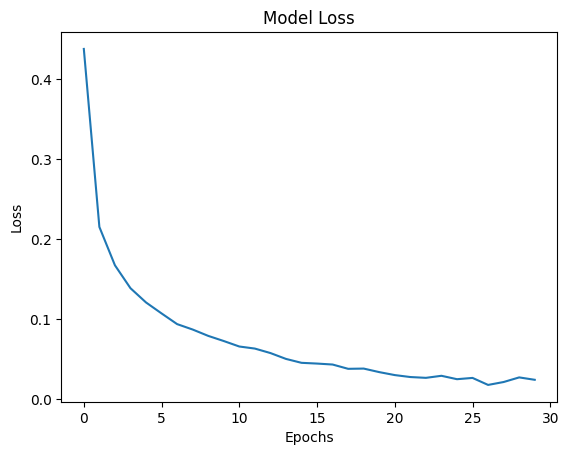

In [13]:
def plot_history(hist):
    plt.plot(hist)
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()
    
plot_history(hist);

In [14]:
train_predictions = np.argmax(NN.predict(train_data), axis = 1)
print("Training accuracy: ", accuracy_score(train["label"].to_numpy(), train_predictions))
test_predictions = np.argmax(NN.predict(test_data), axis = 1)
print("Test accuracy: ", accuracy_score(test["label"].to_numpy(), test_predictions))

Training accuracy:  0.9894897959183674
Test accuracy:  0.9495238095238095


In [15]:
def predict_image(index):
    current_image = test_data[index, :]
    prediction = np.argmax(NN.predict(current_image), axis = 1)
    label = test["label"].to_numpy()[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation = "nearest")
    plt.show()

Prediction:  [5]
Label:  5


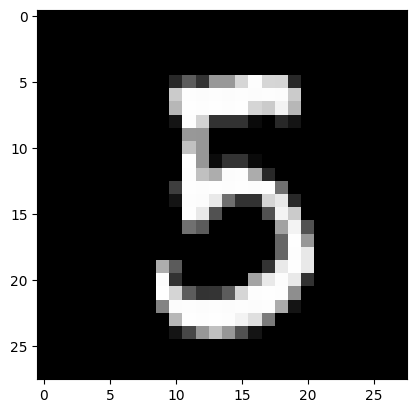

In [16]:
predict_image(1)

Prediction:  [4]
Label:  4


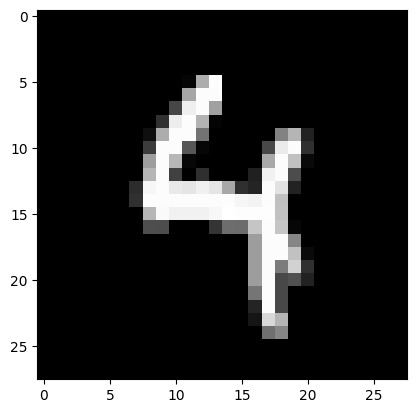

In [17]:
predict_image(2)

Prediction:  [2]
Label:  2


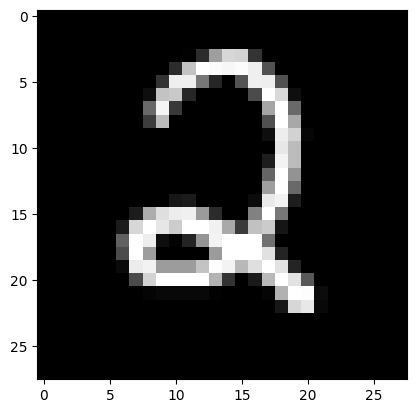

In [18]:
predict_image(3)

### **Binary-Class Classification**

### **Dataset: [Breast Cancer Wisconsin (Diagnostic) Data Set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29)**

In [19]:
data = pd.read_csv("binaryclass_train.csv", header = None)
data["label"] = data[1].apply(lambda x: 1 if x == "M" else 0)
train, test = train_test_split(data, test_size = 0.3)
train_data = train.loc[:, ~train.columns.isin([0, 1, "label"])].to_numpy()
train_target = train["label"].to_numpy()
test_data = test.loc[:, ~test.columns.isin([0, 1, "label"])].to_numpy()
test_target = test["label"].to_numpy()

In [20]:
train

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,label
361,901041,B,13.30,21.57,85.24,546.1,0.08582,0.06373,0.03344,0.02424,...,29.20,92.94,621.2,0.1140,0.16670,0.12120,0.05614,0.2637,0.06658,0
186,874217,M,18.31,18.58,118.60,1041.0,0.08588,0.08468,0.08169,0.05814,...,26.36,139.20,1410.0,0.1234,0.24450,0.35380,0.15710,0.3206,0.06938,1
199,877500,M,14.45,20.22,94.49,642.7,0.09872,0.12060,0.11800,0.05980,...,30.12,117.90,1044.0,0.1552,0.40560,0.49670,0.18380,0.4753,0.10130,1
389,90312,M,19.55,23.21,128.90,1174.0,0.10100,0.13180,0.18560,0.10210,...,30.44,142.00,1313.0,0.1251,0.24140,0.38290,0.18250,0.2576,0.07602,1
388,903011,B,11.27,15.50,73.38,392.0,0.08365,0.11140,0.10070,0.02757,...,18.93,79.73,450.0,0.1102,0.28090,0.30210,0.08272,0.2157,0.10430,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,907914,M,14.90,22.53,102.10,685.0,0.09947,0.22250,0.27330,0.09711,...,27.57,125.40,832.7,0.1419,0.70900,0.90190,0.24750,0.2866,0.11550,1
371,9012568,B,15.19,13.21,97.65,711.8,0.07963,0.06934,0.03393,0.02657,...,15.73,104.50,819.1,0.1126,0.17370,0.13620,0.08178,0.2487,0.06766,0
465,9113239,B,13.24,20.13,86.87,542.9,0.08284,0.12230,0.10100,0.02833,...,25.50,115.00,733.5,0.1201,0.56460,0.65560,0.13570,0.2845,0.12490,0
60,858970,B,10.17,14.88,64.55,311.9,0.11340,0.08061,0.01084,0.01290,...,17.45,69.86,368.6,0.1275,0.09866,0.02168,0.02579,0.3557,0.08020,0


In [21]:
NN = NeuralNetwork(input_size = train_data.shape[1])
NN.add_layer(16, "relu")
NN.add_layer(16, "relu")
NN.add_layer(1, "sigmoid")
NN.compile(loss = "binary crossentropy")
NN.summary()

---- Model Summary ----
Layer 1: relu
W: (16, 30) b: (16, 1)
Trainable parameters: 496
Layer 2: relu
W: (16, 16) b: (16, 1)
Trainable parameters: 272
Layer 3: sigmoid
W: (1, 16) b: (1, 1)
Trainable parameters: 17


In [22]:
hist = NN.fit(train_data, train_target, epochs = 1000, batch_size = 32, learning_rate = 0.01, verbose = 0)

Training finished after epoch 1000 with a loss of 0.166389194481977.


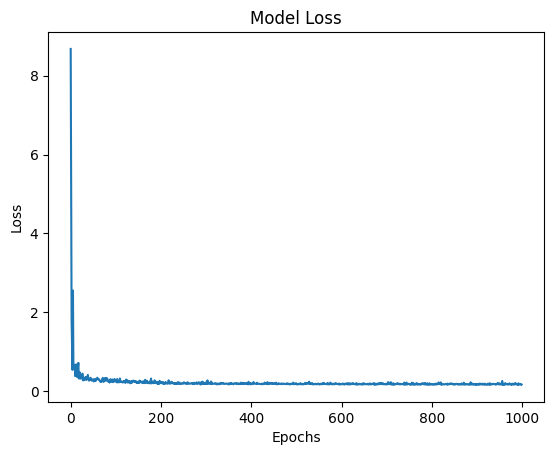

In [23]:
plot_history(hist);

In [24]:
train_predictions = np.round(NN.predict(train_data))
print("Training accuracy: ", accuracy_score(train["label"].to_numpy(), train_predictions))
test_predictions = np.round(NN.predict(test_data))
print("Test accuracy: ", accuracy_score(test["label"].to_numpy(), test_predictions))

Training accuracy:  0.8869346733668342
Test accuracy:  0.8888888888888888
